# Image Denoising

Acquired images are corrupted by noise. Noise are random variations that are due
the intrinsic quantic nature of light and thermal agitation of electrons in the 
circuits. 

Denoising is a fundamental problem in image processing as it requires to
model the nature of the image itself and therefore provided a good experimental
validation. Over the years many approaches have been proposed for
denoising images based on various assumption on the image.

Experimental validation:




T. Plotz and S. Roth, ‘Benchmarking Denoising Algorithms With Real Photographs’, presented at the Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, 2017, pp. 1586–1595. Available: https://openaccess.thecvf.com/content_cvpr_2017/html/Plotz_Benchmarking_Denoising_Algorithms_CVPR_2017_paper.html



## BM3D

BM3D is one of the most performant approach for method not actively based on 
learning.

Y. Mäkinen, L. Azzari, A. Foi, 2020, "Collaborative Filtering of Correlated Noise: Exact Transform-Domain Variance for Improved Shrinkage and Patch Matching", in IEEE Transactions on Image Processing, vol. 29, pp. 8339-8354.

We can install BM3D from pip
```
    pip install bm3d
```


In [2]:
# Run this cell is your are developing the code locally
%load_ext autoreload
%autoreload 2
import sys
import site
site.addsitedir('../') 

Let's apply the denoising method on a test image

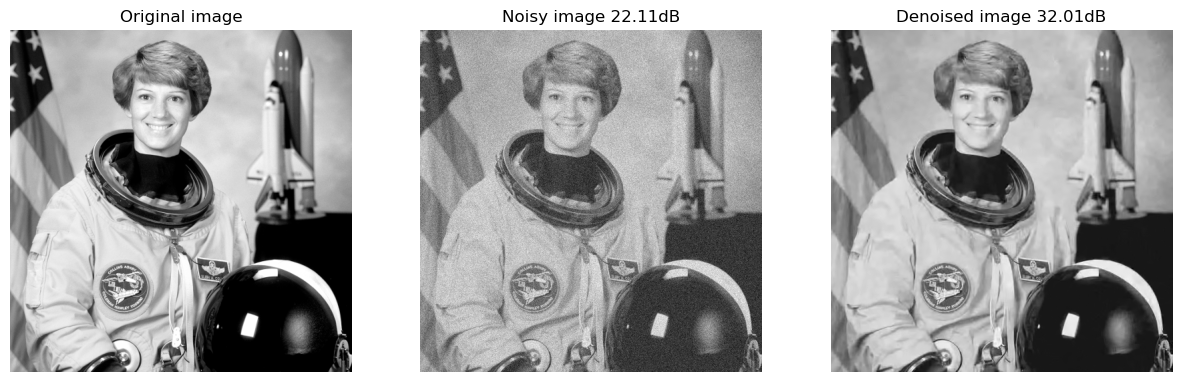

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from bm3d import bm3d
import skimage

noise_std = 20
im = skimage.data.astronaut()[:,:,0]
noise = np.random.normal(0, noise_std, im.shape)
noisy = im.copy() + noise
denoised = bm3d(noisy, noise_std)

# display the result with quality metric
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(im, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(noisy, cmap='gray')
ax[1].set_title(f'Noisy image {skimage.metrics.peak_signal_noise_ratio(im, noisy, data_range=255):.2f}dB')
ax[2].imshow(denoised, cmap='gray')
ax[2].set_title(f'Denoised image {skimage.metrics.peak_signal_noise_ratio(im, denoised, data_range=255):.2f}dB')
for a in ax:
    a.set_axis_off()

Benchmarking

In [11]:
from mug import denoising
result_bm3d = denoising.benchmark(bm3d, '../data/Set12/*.png')

Text(0.5, 1.0, 'Set12 Benchmark for BM3D')

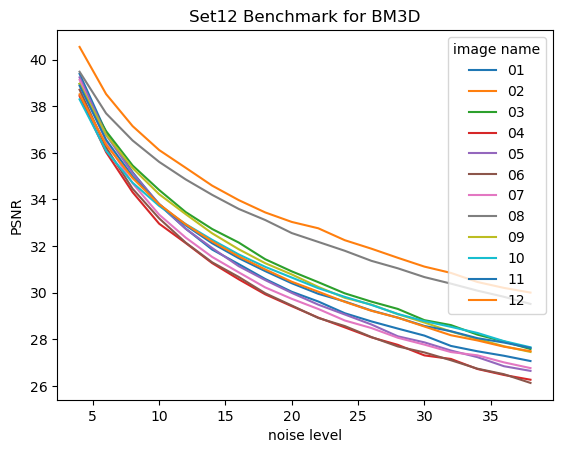

In [24]:
result_bm3d.pivot_table('psnr','noise level','image name').plot()
plt.ylabel('PSNR')
plt.title('Set12 Benchmark for BM3D')

## DnCNN
In DnCNN the task is set to predict the the residual image between the noisy and
the noise free image. The network is composed of a deep (17 stage) sequence of 
blocks composed of convolution, batch normalization and RELU. The training is 
done by cropping 50x50 patches of images.

A supervised with known noise level and a blind version can be trained.

Zhang, Kai, et al. "Beyond a gaussian denoiser: Residual learning of deep cnn for 
image denoising." IEEE transactions on image processing 26.7 (2017): 3142-3155.

Text(0, 0.5, 'Loss')

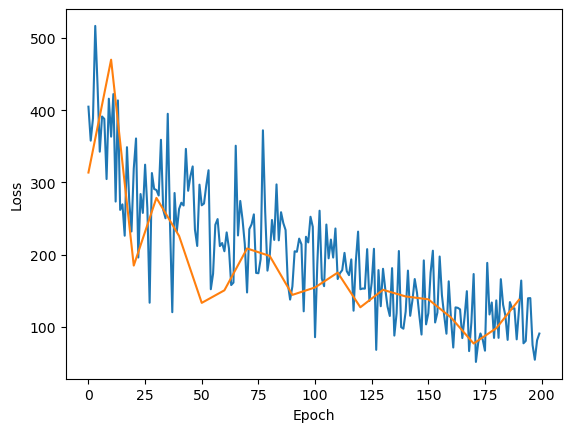

In [8]:
from mug import denoising
from mug import utils
import torch
from torch.utils.data import Dataset, DataLoader
from torch import optim
import torch.nn as nn
import matplotlib.pyplot as plt

model = denoising.DnCNN()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
train_dataset = denoising.DnCNNDataset('../data/Set12/*', denoising.DnCNNAugmenter([64,64], [5,30]))
valid_dataset = denoising.DnCNNDataset('../data/Set12/*', denoising.DnCNNAugmenter([64,64], [5,30]))
train_dl = DataLoader(train_dataset, batch_size=16)
valid_dl = DataLoader(valid_dataset, batch_size=16)
num_epochs = 200
optimizer = optim.AdamW(model.parameters(), lr=3e-3)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_dl), epochs=num_epochs)
loss_fn = nn.MSELoss()
history = utils.train_network(model,optimizer,loss_fn,train_dl,valid_dl,num_epochs,device)
plt.plot(history['train_epoch'],history['train_loss'])
plt.plot(history['valid_epoch'],history['valid_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [10]:
from mug import denoising
dncnn = denoising.DnCNNDenoiser(model)
result_dncnn = denoising.benchmark(dncnn, '../data/Set12/*.png', blind=True)

Text(0.5, 1.0, 'Set12 Benchmark for BM3D')

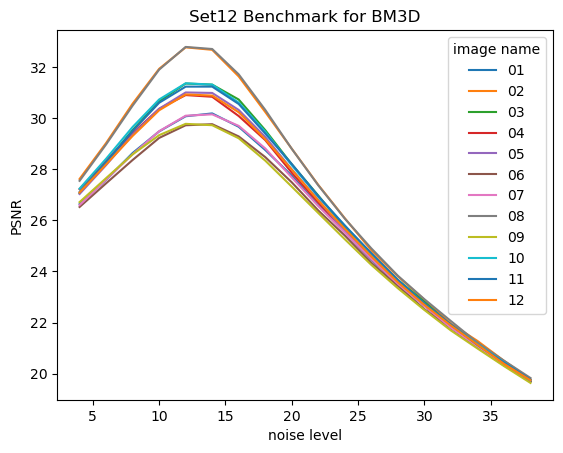

In [7]:
result_dncnn.pivot_table('psnr','noise level','image name').plot()
plt.ylabel('PSNR')
plt.title('Set12 Benchmark for BM3D')

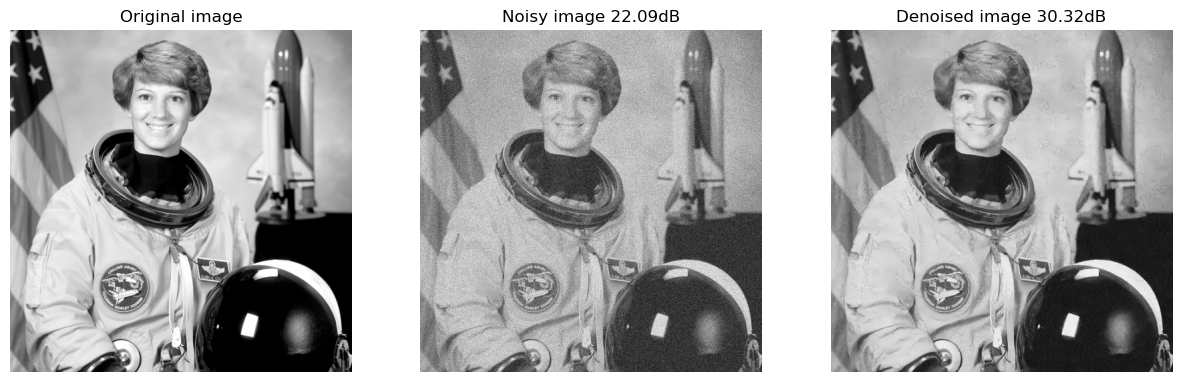

In [33]:
import skimage
import numpy as np
from mug import denoising

def psnr(x, y, vmax = 255):
    """Peak signal to noise ratio quality metric"""
    import math
    return 10 * math.log10(vmax * vmax / np.mean(np.square(x - y)))
    
noise_std = 20
im = skimage.data.astronaut()[:,:,0]
noise = np.random.normal(0, noise_std, im.shape)
noisy = im.copy() + noise

dncnn = denoising.DnCNNDenoiser(model)
denoised = dncnn(noisy)

# display the result with quality metric
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(im, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(noisy, cmap='gray')
ax[1].set_title(f'Noisy image {psnr(noisy, im):.2f}dB')
ax[2].imshow(denoised, cmap='gray')
ax[2].set_title(f'Denoised image {psnr(denoised, im):.2f}dB')
for a in ax:
    a.set_axis_off()

## 


In [202]:
class Block2D(nn.Module):
    def __init__(self,n):
        super(Block2D, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(n, n, 3, 1, 1, bias=False),
            nn.BatchNorm2d(n),
            nn.LeakyReLU(negative_slope=0.2)
        )        
    def forward(self,x):
        return self.net(x)

class UNet2D(nn.Module):
    def __init__(self, block, in_channels=1, out_channels=1, nfeatures=[4,8]):
        super(UNet2D, self).__init__()        
        self.head = nn.Conv2d(in_channels, nfeatures[0], 3, 1, 1, bias=False)
        self.down = nn.ModuleList([
            nn.Sequential(
                block(nfeatures[k]),
                block(nfeatures[k]),
                nn.Conv2d(nfeatures[k], nfeatures[k+1], 3, 1, 1, bias=False)              
            )
            for k in range(len(nfeatures)-1)            
        ])
        self.body =  block(nfeatures[-1])
        self.up = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(nfeatures[-k-1], nfeatures[-k-2], 3, 1, 1, bias=False),
                block(nfeatures[-k-2]),
                block(nfeatures[-k-2])
            )
            for k in range(len(nfeatures)-1)            
        ])

    def forward(self,x):
        z = [self.head(x)]
        for k, layer in enumerate(self.down):
            z.append(layer(z[k]))
        y = self.body(z[-1])
        for k, layer in enumerate(self.up):
            y = layer(y+z[-k-1])
        return self.tail(y)

net = UNet2D(Block2D)


In [205]:
z = [1]
[1, *[x for x in range(5)] ]

[1, 0, 1, 2, 3, 4]